In [ ]:
# Собрать отформатированный график, привести показатели к одному значению

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


from tqdm import tqdm
import warnings
warnings.simplefilter('ignore') 

# Для сортировки по месяцам
from sorted_months_weekdays import *

from sort_dataframeby_monthorweek import *

# Для автоматического закрытия курсора
from contextlib import closing

%matplotlib inline

import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine
# Для автоматического закрытия курсора
from contextlib import closing

import requests
import json
from datetime import datetime
import time

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [2]:
import os
from pathlib import Path 

In [3]:
import requests
from bs4 import BeautifulSoup

In [299]:
# Рассчет площади по кривой
from sklearn.metrics import auc
import statsmodels.formula.api as smf

In [5]:
# sns.set(
#     font_scale=2,
#     style="whitegrid",
#     rc={'figure.figsize':(20,10)}
#         )

In [6]:
engine = psycopg2.connect(user="guest_test",
                          # пароль, который указали при установке PostgreSQL
                          password="guest82tester",
                          host="10.157.111.20",
                          port="5432",
                          database="aeforecast")

# Тестовый регион

In [7]:
query_fts_max_region_code = """

            SELECT SUM(trade_value), region, region_code
            FROM cc.fts l LEFT JOIN ref.ref_region r ON l.region_code = r.code
            WHERE commodity_code LIKE('020727%') AND trade_flow_code = '2'
            GROUP BY region, region_code
            ORDER BY SUM(trade_value) DESC
            LIMIT 10

"""

df_fts_max_code = pd.read_sql(query_fts_max_region_code, con=engine)

need_region_code_test = df_fts_max_code.region_code.head(1).to_list()[0]

need_region_code_test

'56000'

# Данные для графика

In [219]:
query_must_data = """

        SELECT trade_value, netweight, period, name_rus   
        FROM cc.fts l LEFT JOIN ref.ref_country r ON l.partner_code = r.code   
        WHERE  region_code = '56000' AND trade_flow_code = '2' AND netweight != 0 AND trade_value != 0 AND period > '2020-12-31'

"""

df_fts_data_need_region = pd.read_sql(query_must_data, con=engine)

df_fts_data_need_region

,trade_value,netweight,period,name_rus
0,13160.00,45900.00,2021-04-01,Киргизия
1,31940.00,23780.00,2022-07-01,Неизвестные территории
2,540.00,140.00,2021-08-13,Вьетнам
3,1080.00,280.00,2021-09-18,Вьетнам
4,1490.00,630.00,2021-12-26,Вьетнам
...,...,...,...,...
7490,81.57,327.41,2021-11-01,Казахстан
7491,196.86,493.26,2021-10-01,Казахстан
7492,78.67,149.82,2021-09-01,Казахстан
7493,144.08,476.07,2021-02-01,Казахстан


In [220]:
df_fts_data_need_region['period'] = pd.to_datetime(df_fts_data_need_region.period)

In [221]:
df_fts_data_need_region['boxplot_iqr'] = df_fts_data_need_region.trade_value / df_fts_data_need_region.netweight

In [222]:
df_fts_data_need_region.dtypes

trade_value           float64
netweight             float64
period         datetime64[ns]
name_rus               object
boxplot_iqr           float64
dtype: object

In [223]:
df_fts_data_need_region.isna().sum()

trade_value    0
netweight      0
period         0
name_rus       0
boxplot_iqr    0
dtype: int64

In [224]:
df_fts_data_need_region.nunique()

trade_value    3328
netweight      2446
period          495
name_rus         57
boxplot_iqr    5574
dtype: int64

In [225]:
df_fts_data_need_region.describe()

,trade_value,netweight,boxplot_iqr
count,7.495000e+03,7.495000e+03,7495.000000
mean,3.068138e+04,3.805453e+04,2.787743
std,7.716127e+04,1.737094e+05,11.520035
min,1.000000e+01,1.000000e+01,0.035322
25%,1.160000e+03,6.350000e+02,1.042193
50%,7.040000e+03,5.030000e+03,1.480000
75%,3.053500e+04,2.350000e+04,2.149761
max,2.349190e+06,5.635300e+06,296.333333


<AxesSubplot:ylabel='boxplot_iqr'>

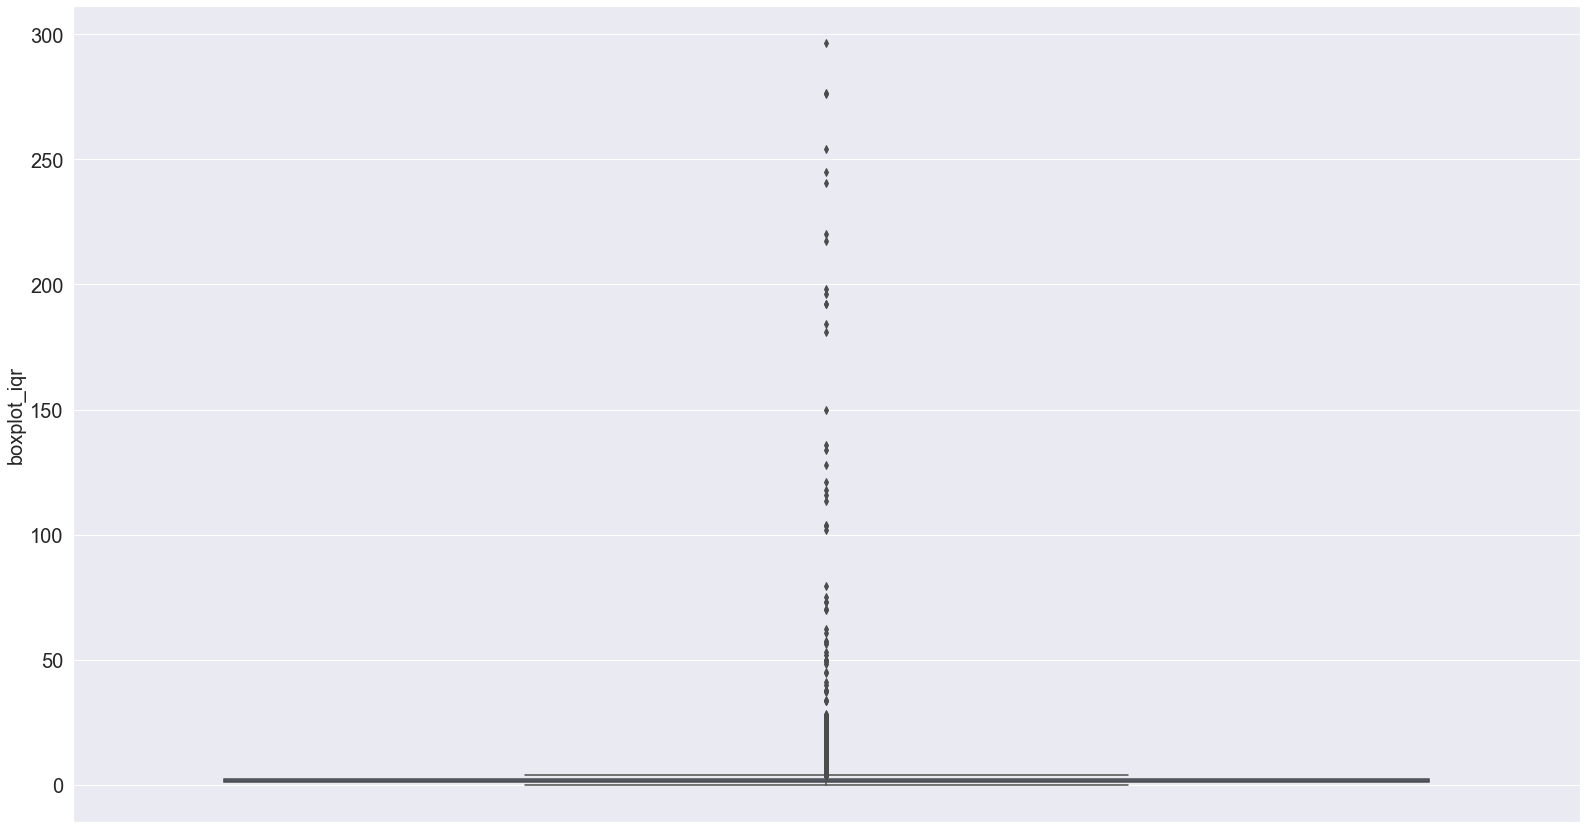

In [226]:
sns.boxplot(y=df_fts_data_need_region.boxplot_iqr)

<AxesSubplot:xlabel='boxplot_iqr', ylabel='Count'>

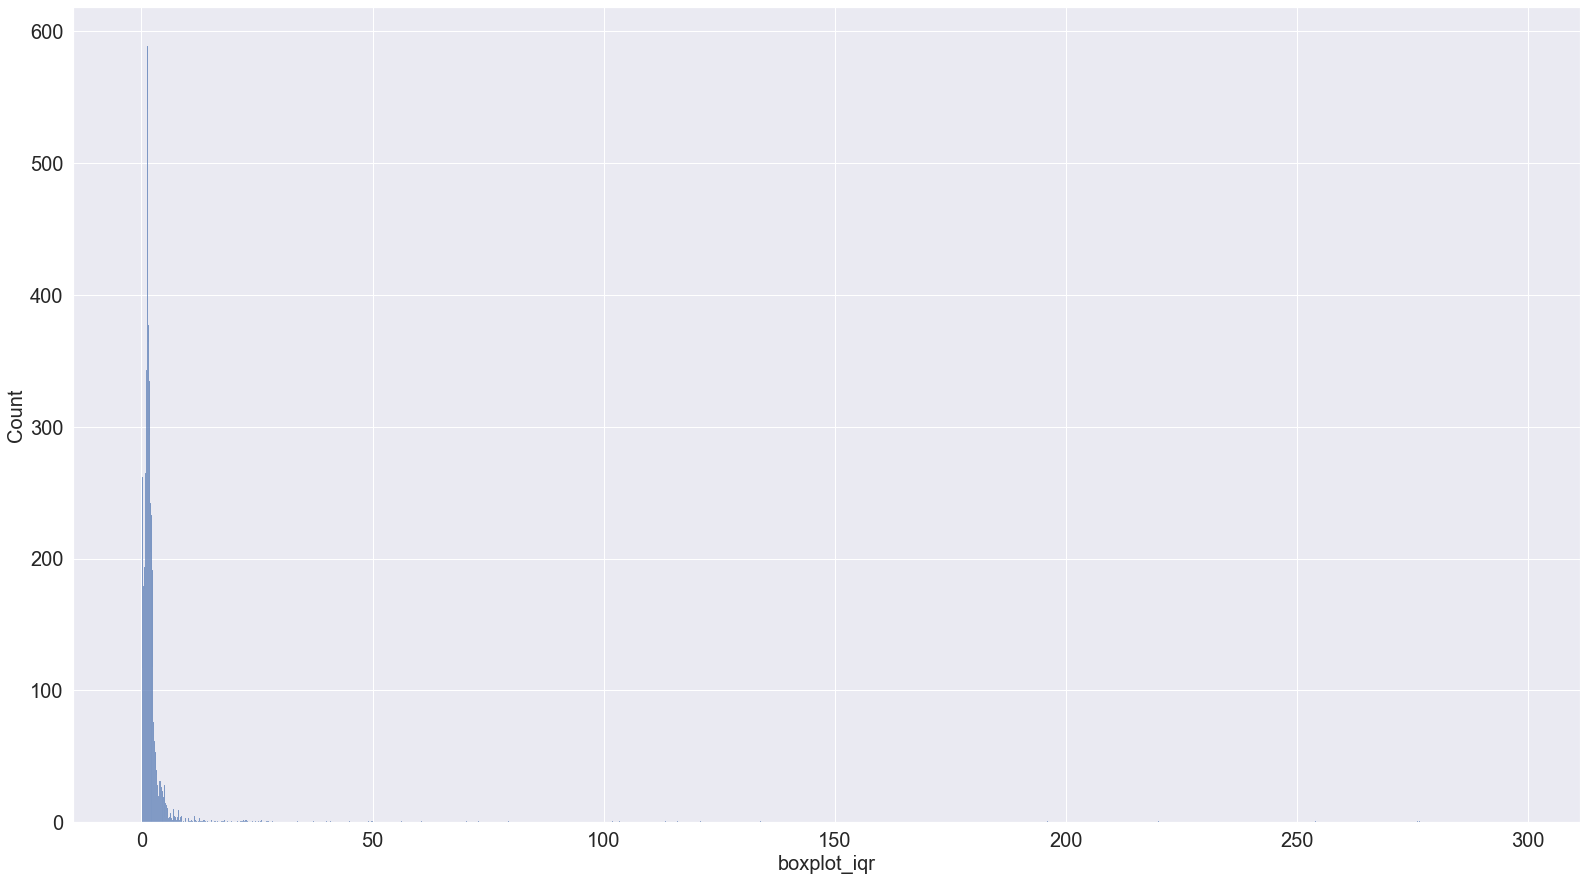

In [227]:
sns.histplot(df_fts_data_need_region.boxplot_iqr)

In [228]:
# df_fts_data_need_region.boxplot_iqr.quantile(q=[0.25, 0.75])

In [229]:
q3, q1 = np.percentile(df_fts_data_need_region.boxplot_iqr, [75,25])
iqr = q3 - q1

In [230]:
df_fts_data_need_region = df_fts_data_need_region[df_fts_data_need_region['boxplot_iqr'] < 3.5 * iqr]

In [231]:
df_fts_data_need_region.nunique()

trade_value    3169
netweight      2413
period          486
name_rus         54
boxplot_iqr    5091
dtype: int64

In [232]:
df_fts_data_need_region.describe()

,trade_value,netweight,boxplot_iqr
count,6.822000e+03,6.822000e+03,6822.000000
mean,2.949718e+04,4.097150e+04,1.486105
std,7.543272e+04,1.817198e+05,0.747235
min,1.000000e+01,1.000000e+01,0.035322
25%,1.240000e+03,8.200000e+02,1.000000
50%,7.420000e+03,6.200000e+03,1.400037
75%,3.112750e+04,2.454750e+04,1.904363
max,2.349190e+06,5.635300e+06,3.875000


<AxesSubplot:ylabel='boxplot_iqr'>

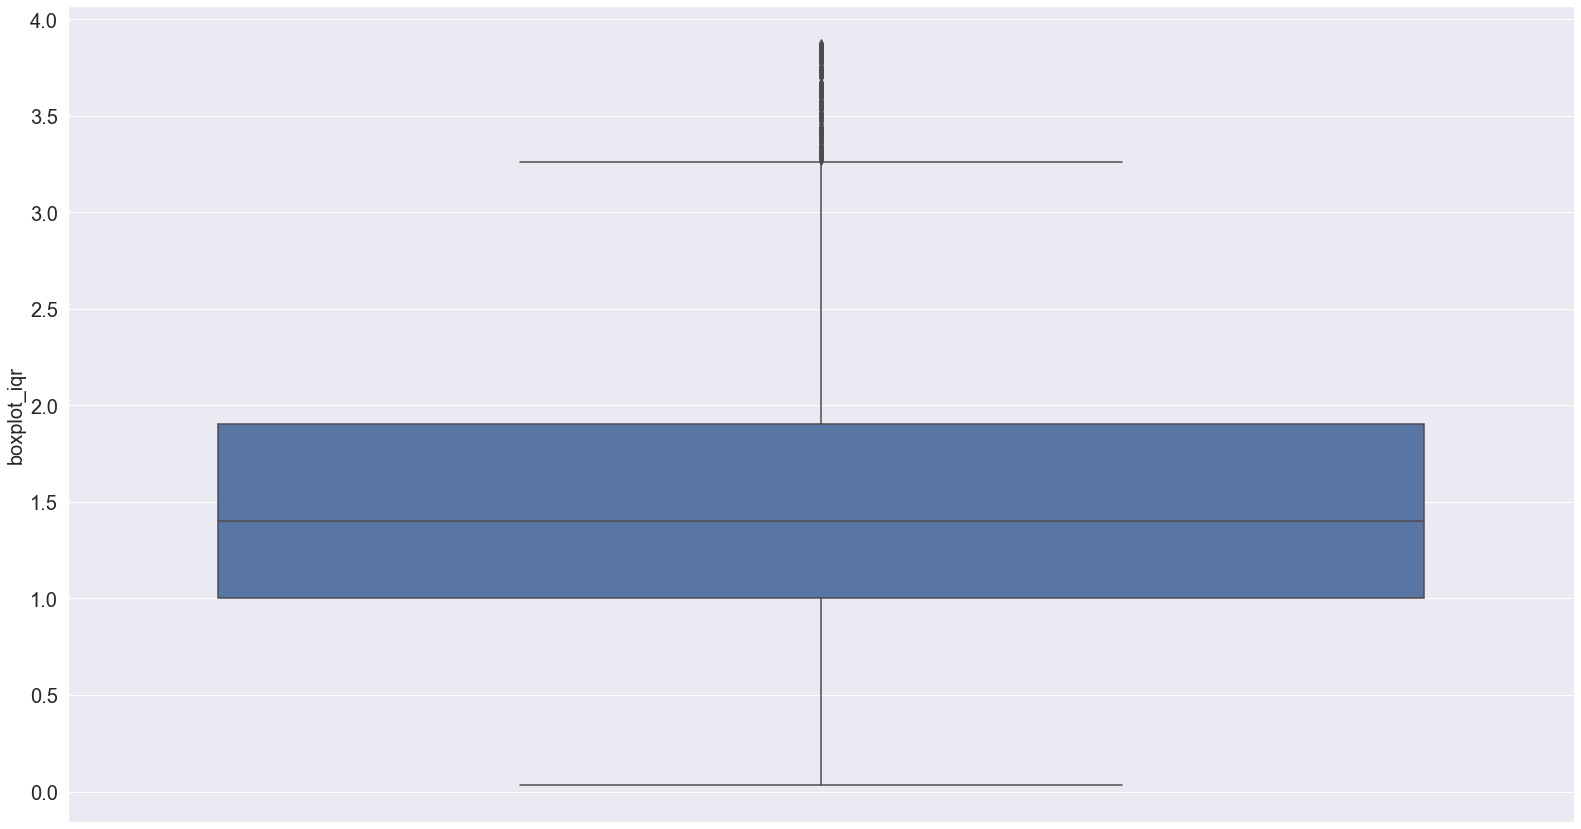

In [233]:
sns.boxplot(y=df_fts_data_need_region.boxplot_iqr)

<AxesSubplot:xlabel='boxplot_iqr', ylabel='Count'>

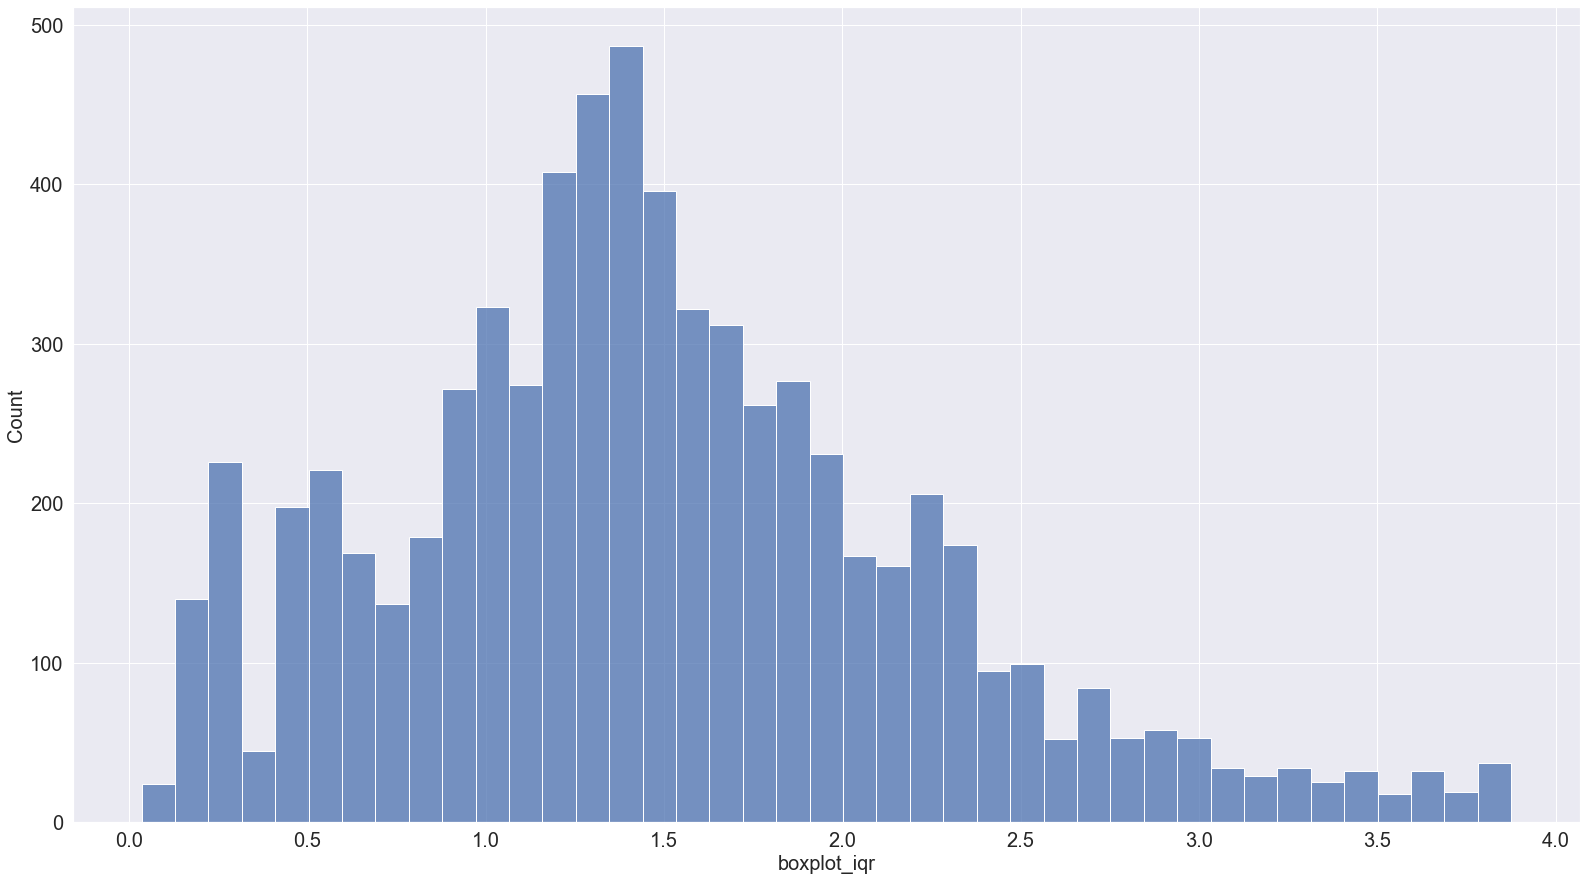

In [234]:
sns.histplot(df_fts_data_need_region.boxplot_iqr)

В части исследования изменения цены за 1 килограмм продукции первоначальные данные дают огромные выбросы, что отражают графики и распределение показателя. После избавления от выбросов(тех показателей, котоыре выше 1.5 МКР), показатели приходят в близкие к реальным и колеблются от 0.03\$  до 3.875000 за килограмм продукции.

Временной промежуток представлен датами от **2021-01-01** до **2022-09-23**

In [235]:
df_fts_data_need_region.period.describe(datetime_is_numeric=True)

count                             6822
mean     2021-09-30 09:51:01.741424896
min                2021-01-01 00:00:00
25%                2021-05-13 00:00:00
50%                2021-09-23 00:00:00
75%                2022-02-01 00:00:00
max                2022-09-24 00:00:00
Name: period, dtype: object

In [74]:
str(df_fts_data_need_region.period.min().strftime('%Y-%m-%d'))

'2021-01-01'

<AxesSubplot:xlabel='netweight', ylabel='boxplot_iqr'>

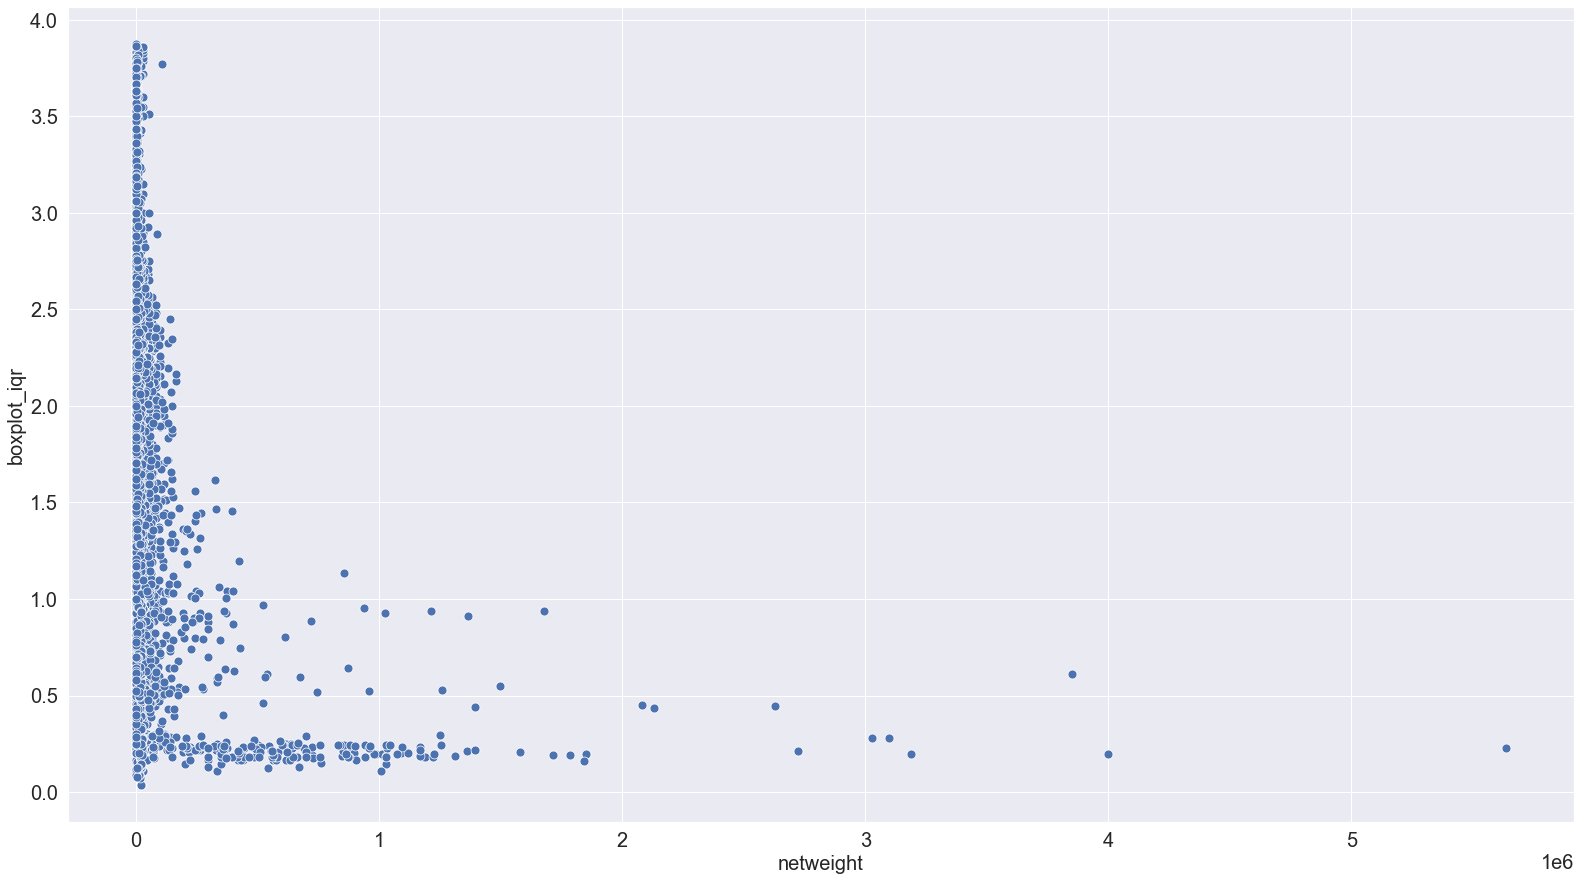

In [272]:
sns.scatterplot(y=df_fts_data_need_region.boxplot_iqr, x=df_fts_data_need_region.netweight, s=80)

# Собираем данные о курсе USD

In [273]:
def read_usd_update(name_file='usd_quotes.xlsx', flag_csv_or_excel='excel', lower_border=str(df_fts_data_need_region.period.min().strftime('%Y-%m-%d')), 
                    name_column_list=['test'],strftime_list=['%Y-%m']):
    """
    name_file - имя файла из которого будут считываться данные
    flag_csv_or_excel - выбор типа считываемого файла (по умолчанию это excel)
    lower_border - нижняя граница таймлайна, до куда мы смотрим курс
    name_column_list - названия столбцов, которые передает пользователь для дальнейшей агрегации
    strftime_list - форматирование дат, которое будет взять для создания новых столбцов
    lst_return - возвращаемый список агрегированных датафреймов
    """
    lst_return=[]
    if flag_csv_or_excel == 'excel':
        df_usd = pd.read_excel(name_file, parse_dates=['updated']).query('updated >= @lower_border')
    else:
        df_usd = pd.read_csv(name_file, parse_dates=['updated']).query('updated >= @lower_border')
    df_usd['bool'] = df_usd.price.apply(lambda x: False if x.startswith('20') else True)
    df_usd = df_usd.loc[df_usd['bool']]
    df_usd['price'] = df_usd.price.apply(lambda x: float(x))

    # Создадим колонку для группировки
    for name, date in zip(name_column_list, strftime_list):
        df_usd[name] = df_usd.updated.apply(lambda x: x.strftime(date))
    
    for column in name_column_list:
#         df_agg = df_usd.groupby(column, as_index=False).agg({'price':'mean'})[df_usd[column] < str(df_fts_data_need_region.period.max())]
        df_agg = df_usd.groupby(column, as_index=False).agg({'price':'mean'})[df_usd[column] < 
                                                                              str(df_fts_data_need_region.period.max().strftime('%Y-%m-%d'))]
        lst_return.append(df_agg)
    return lst_return
        

In [274]:
d, m, y = read_usd_update(name_column_list=['day', 'month', 'year'], strftime_list=['%Y-%m-%d', '%Y-%m', '%Y'])

In [275]:
m['month_2'] = pd.to_datetime(m.month)
m

,month,price,month_2
0,2021-01,74.416447,2021-01-01
1,2021-02,74.324725,2021-02-01
2,2021-03,74.397133,2021-03-01
3,2021-04,76.143932,2021-04-01
4,2021-05,73.988310,2021-05-01
5,2021-06,72.616857,2021-06-01
6,2021-07,73.889891,2021-07-01
7,2021-08,73.582733,2021-08-01
8,2021-09,72.926218,2021-09-01
9,2021-10,71.450091,2021-10-01


# Преобразование данных 

In [276]:
df_fts_data_need_region.head()

,trade_value,netweight,period,name_rus,boxplot_iqr,month,month_2
0,13160.0,45900.0,2021-04-01,Киргизия,0.286710,2021-04,2021-04-01
1,31940.0,23780.0,2022-07-01,Неизвестные территории,1.343146,2022-07,2022-07-01
2,540.0,140.0,2021-08-13,Вьетнам,3.857143,2021-08,2021-08-01
3,1080.0,280.0,2021-09-18,Вьетнам,3.857143,2021-09,2021-09-01
4,1490.0,630.0,2021-12-26,Вьетнам,2.365079,2021-12,2021-12-01


In [277]:
df_fts_data_need_region['month'] = df_fts_data_need_region.period.apply(lambda x: x.strftime('%Y-%m'))
df_fts_data_need_region['month_2'] = pd.to_datetime(df_fts_data_need_region.month)

In [278]:
query_patrtner_need = df_fts_data_need_region.groupby(['month_2', 'name_rus'], as_index=False) \
                                            .agg({'trade_value':'sum', 'netweight': 'sum'})
query_patrtner_need['unit_price'] = round(query_patrtner_need.trade_value / query_patrtner_need.netweight, 2)

query_patrtner_need = query_patrtner_need.merge(m, on='month_2', how='left')

query_patrtner_need['rub'] = round(query_patrtner_need.unit_price * query_patrtner_need.price, 2)
query_patrtner_need['test'] = query_patrtner_need.month_2.apply(lambda x: time.mktime(x.timetuple()))

In [279]:
query_patrtner_need.query('rub > 140')

,month_2,name_rus,trade_value,netweight,unit_price,month,price,rub,test
0,2021-01-01,Абхазия,15550.0,6890.0,2.26,2021-01,74.416447,168.18,1.609448e+09
7,2021-01-01,Гонконг (Китай),72840.0,26980.0,2.70,2021-01,74.416447,200.92,1.609448e+09
19,2021-01-01,Нидерланды,540.0,200.0,2.70,2021-01,74.416447,200.92,1.609448e+09
20,2021-01-01,ОАЭ,186120.0,53000.0,3.51,2021-01,74.416447,261.20,1.609448e+09
43,2021-02-01,ОАЭ,95850.0,27000.0,3.55,2021-02,74.324725,263.85,1.612127e+09
...,...,...,...,...,...,...,...,...,...
570,2022-09-01,Германия,2180.0,760.0,2.87,2022-09,60.356795,173.22,1.661980e+09
571,2022-09-01,Грузия,44430.0,18220.0,2.44,2022-09,60.356795,147.27,1.661980e+09
572,2022-09-01,Китай,511690.0,185370.0,2.76,2022-09,60.356795,166.58,1.661980e+09
576,2022-09-01,Монголия,54690.0,20120.0,2.72,2022-09,60.356795,164.17,1.661980e+09


<AxesSubplot:ylabel='rub'>

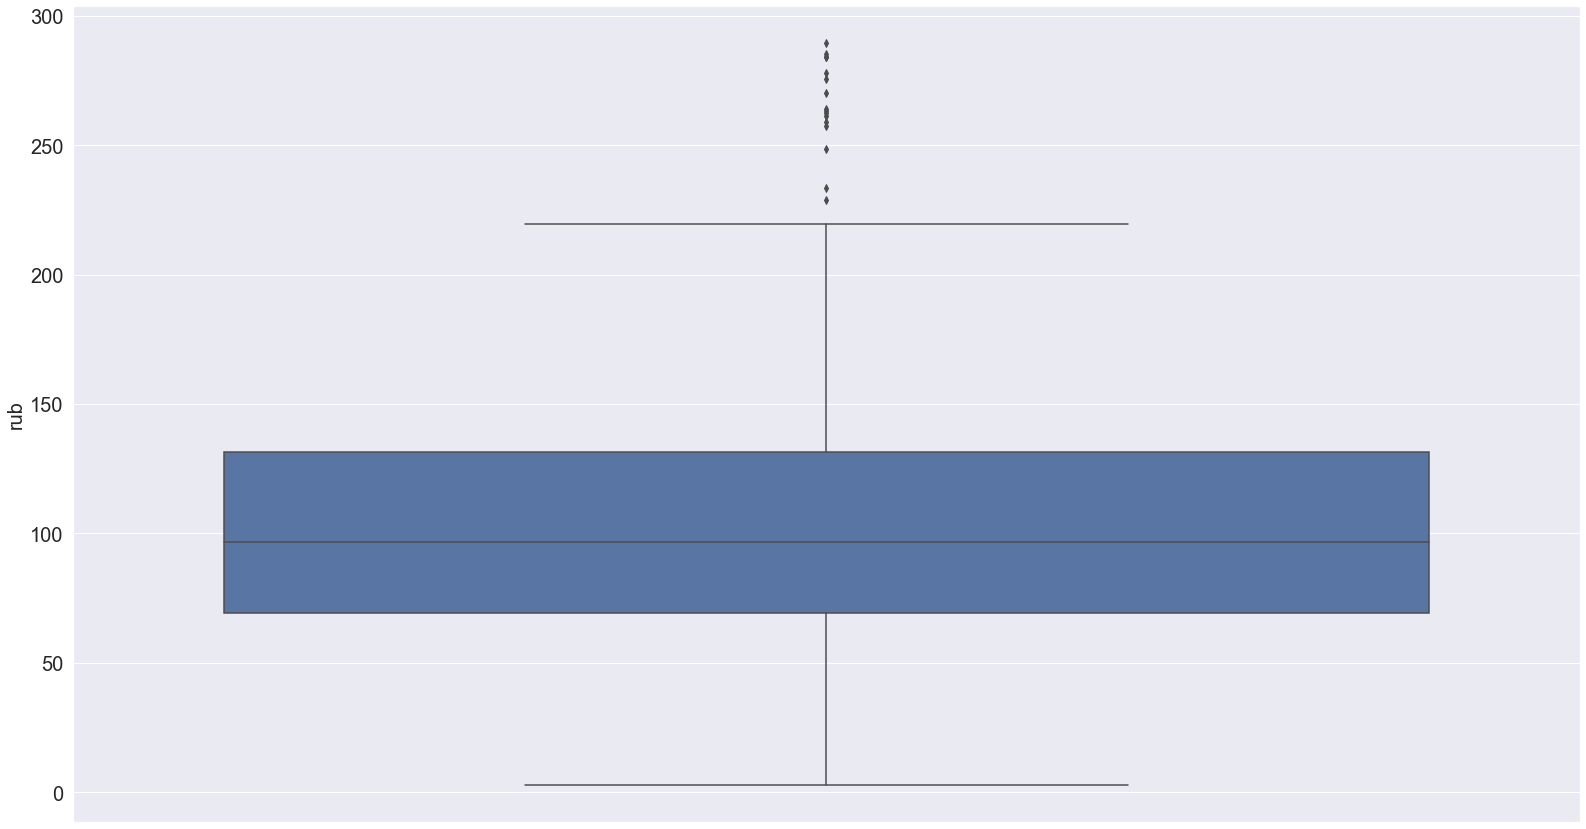

In [280]:
sns.boxplot(y=query_patrtner_need.rub)

In [281]:
query_patrtner_need.sort_values(by='month_2', inplace=True)

In [282]:
query_patrtner_need['rank_date'] = query_patrtner_need.month_2.rank(method='dense')

In [283]:
r_labels = range(1, 5)
query_patrtner_need['rank_date'] = pd.qcut(query_patrtner_need['month_2'].rank(method='first'), q=4, labels=r_labels)

In [284]:
query_patrtner_need

,month_2,name_rus,trade_value,netweight,unit_price,month,price,rub,test,rank_date
0,2021-01-01,Абхазия,15550.0,6890.0,2.26,2021-01,74.416447,168.18,1.609448e+09,1
25,2021-01-01,Эстония,164050.0,636050.0,0.26,2021-01,74.416447,19.35,1.609448e+09,1
24,2021-01-01,Украина,1868920.0,1100810.0,1.70,2021-01,74.416447,126.51,1.609448e+09,1
23,2021-01-01,Узбекистан,213670.0,285610.0,0.75,2021-01,74.416447,55.81,1.609448e+09,1
22,2021-01-01,Туркменистан,113360.0,170660.0,0.66,2021-01,74.416447,49.11,1.609448e+09,1
...,...,...,...,...,...,...,...,...,...,...
564,2022-09-01,Азербайджан,293430.0,272710.0,1.08,2022-09,60.356795,65.19,1.661980e+09,4
563,2022-09-01,Абхазия,16460.0,19170.0,0.86,2022-09,60.356795,51.91,1.661980e+09,4
581,2022-09-01,Узбекистан,897150.0,982520.0,0.91,2022-09,60.356795,54.92,1.661980e+09,4
571,2022-09-01,Грузия,44430.0,18220.0,2.44,2022-09,60.356795,147.27,1.661980e+09,4


In [287]:
dct = {}

for i in list(query_patrtner_need.name_rus.unique()):
    if list(query_patrtner_need.name_rus.value_counts().reset_index().query('index == @i').name_rus)[0] > 1:
        xx = query_patrtner_need.query('name_rus == @i').rank_date
        yy = query_patrtner_need.query('name_rus == @i').rub
        dct[i] = round(auc(xx,yy), 2)
dict(sorted(dct.items(), key=lambda x: x[1], reverse=True))

{'ОАЭ': 736.24,
 'Бенин': 476.57,
 'Германия': 457.63,
 'Китай': 446.87,
 'Сербия': 403.18,
 'Молдова': 401.33,
 'Туркменистан': 382.58,
 'Монголия': 376.08,
 'Абхазия': 347.43,
 'Азербайджан': 326.53,
 'Габон': 315.04,
 'Великобритания': 304.8,
 'Израиль': 303.25,
 'Либерия': 295.46,
 'Беларусь': 294.02,
 'Нидерланды': 286.37,
 'Украина': 285.82,
 'Демократическая Республика Конго': 284.08,
 'Армения': 282.62,
 'США': 279.91,
 'Грузия': 279.26,
 'Ангола': 265.84,
 'Экваториальная Гвинея': 258.06,
 'Бельгия': 256.0,
 'Киргизия': 247.46,
 'Таджикистан': 238.86,
 'Вьетнам': 234.62,
 'Турция': 227.56,
 'Узбекистан': 221.08,
 'Гонконг (Китай)': 213.88,
 'Гана': 198.5,
 'Швейцария': 188.32,
 'Литва': 187.03,
 'Италия': 167.43,
 'Казахстан': 159.22,
 'Неизвестные территории': 142.55,
 'Польша': 140.05,
 'Гвинея': 116.03,
 'Эстония': 108.82,
 'Гаити': 97.3,
 'Латвия': 46.64,
 'Испания': 42.17,
 'Южная Осетия': 0.0,
 'Конго': 0.0,
 'Ирак': 0.0,
 'Швеция': 0.0}

In [317]:
df_group = df_fts_data_need_region.groupby(['month', 'name_rus'], as_index=False) \
                                            .agg({'trade_value':'sum', 'netweight': 'sum'})

In [318]:
df_group['unit_price'] = round(df_group.trade_value / df_group.netweight, 2)

In [319]:
df_group = df_group.merge(m, on='month', how='left')

In [320]:
df_group['rub'] = round(df_group.unit_price * df_group.price, 2)

In [321]:
df_group['area'] = df_group.name_rus.apply(lambda x: dct[x] if x in dct else 0)

In [322]:
l = df_group.sort_values(by='area', ascending=False).name_rus.unique().tolist()[:3]
# l = ['Китай',
#  'Бенин' ,
#  'Бельгия' ,
#  'Таджикистан']

In [323]:
df_group = df_group.query('name_rus in @l')

# df_fts_data_need_region = df_fts_data_need_region.query('name_rus in @l')

In [324]:
sns.set(rc={'figure.figsize':(27, 15), 'axes.titlesize':20, 'axes.labelsize':20, 'xtick.labelsize':20, 
            'ytick.labelsize':20,'axes.titlepad': 35#, 'font.family': 'Roboto' 
           })

In [325]:
df_group['name_rus'].unique().tolist()

['Бенин', 'Германия', 'ОАЭ']

In [326]:
df_group.sort_values(by='month', inplace=True)
df_group['rank_date'] = df_group['month'].rank(method='dense')

In [403]:
def test_plot(df, group_val=None, title_legend=None, ax=None, color_list=['#5d567e'], title_fig=None, pp=''):
    """Функция для построения графиков за несколько лет. 
    По оси х - временной промежуток, у - цена. 
    Также возможна группировка по еще одной переменной, например, страны партнеры.
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    group_val: str, optional
        Название группирующей переменной
    title_legend: str, optional
        Название легенды 
    ax: axis, optional
        Если объект axis уже создан (полезно при построении нескольких графиков сразу)
    color: str, optional
        Цвет линии
    title_fig: str, optional
        Название продукта в подписи графика
    """
    
    
    
    if ax is None:
        fig, ax = plt.subplots()
        
#     if group_val:
#         for value in df[group_val].unique().tolist()[::-1]:
#             ax.plot(df[df[group_val]==value].group_period, df[df[group_val]==value].unit_price, label=value,
#                    linewidth=3, markersize=6, marker='o')
#             ax.legend(df[group_val].unique().tolist(), title=title_legend, loc='best', framealpha=0)
    if group_val:
        palette = {}
        for k, v in zip(df[group_val].unique().tolist(), color_list):
            palette[k] = v
        sns.lineplot(x=df.month, y=df.rub, hue=df[group_val], marker= 'o', markersize=10, linewidth=3, 
                          palette=palette, ax=ax)
        for list_val, color in zip(df[group_val].unique().tolist(), color_list):

            z = np.polyfit (df[df[group_val] == list_val].rank_date, df[df[group_val] == list_val].rub, 2 )
            p = np.poly1d (z)
            sns.lineplot(df[df[group_val] == list_val].rank_date, p(df[df[group_val] == list_val].rank_date), linewidth=3, 
                         ax=ax, color=color, marker= 'o', markersize=10)
            plt.legend(labels=list_val, fontsize = 'large', title_fontsize = "10")
        ax.legend(df[group_val].unique().tolist(), title=title_legend, loc='best', framealpha=0, prop={'size': 27})
        plt.setp(ax.get_legend().get_title(), fontsize='32')

    else:
        ax = sns.lineplot(x=df.month, y=df.price, marker= 'o', markersize=10, linewidth=3, ax=ax, legend='full')
        ax.legend(df.columns.tolist(),title=title_legend, loc='best', framealpha=0, prop={'size': 27})
        plt.setp(ax.get_legend().get_title(), fontsize='32')
        
    ax.set(xlabel='Месяцы', ylabel='Цена за кг. продукции', 
           title=f'Распределение изменения цены продукта: {title_fig}')
    # чтобы было красиво
    ax.set_frame_on(False) # sns.despine() 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f'{int(y)}₽'))
#     ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%d'))
#     ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
#     ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.tick_params(axis='x', rotation=45)
    
    ax.grid(True, color='#e2e2e2', alpha=1)




In [367]:
df_group.columns.tolist()

['month',
 'name_rus',
 'trade_value',
 'netweight',
 'unit_price',
 'price',
 'month_2',
 'rub',
 'area',
 'rank_date']

In [307]:
df_group.head(1)

,month,name_rus,trade_value,netweight,unit_price,price,month_2,rub,area,rank_date
5,2021-01,Бенин,192170.0,135000.0,1.42,74.416447,2021-01-01,105.67,476.57,1.0


In [300]:
#the trendline    
# z = np.polyfit( df_group["rub"] , df_group.month, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"r--")

# plt.show()


# model = smf.ols('rub ~ month', data= df_group.query('name_rus == "ОАЭ"')).fit()
# model.summary()
# df_group = df_group.query('name_rus == "ОАЭ"')
# df_group.assign(fit=model.fittedvalues).plot(x='xcol', y='fit', ax=ax)

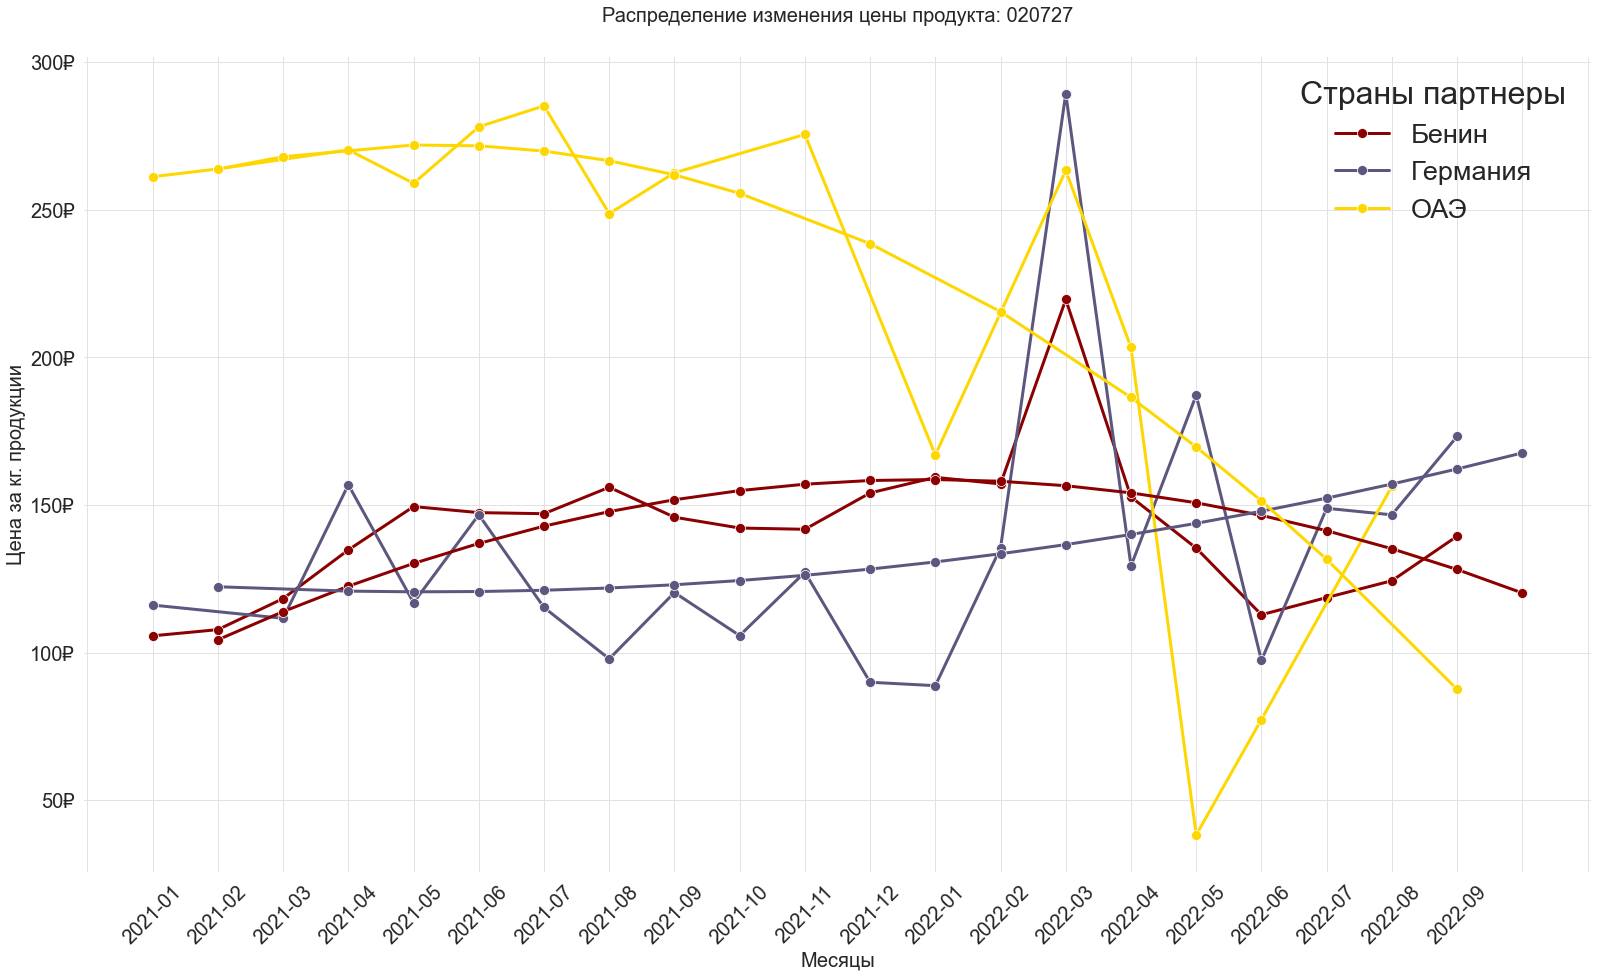

In [404]:
test_plot(df_group, group_val='name_rus',  title_legend='Страны партнеры',  title_fig='020727', color_list=['#8B0000', '#5d567e', '#FFD700'])

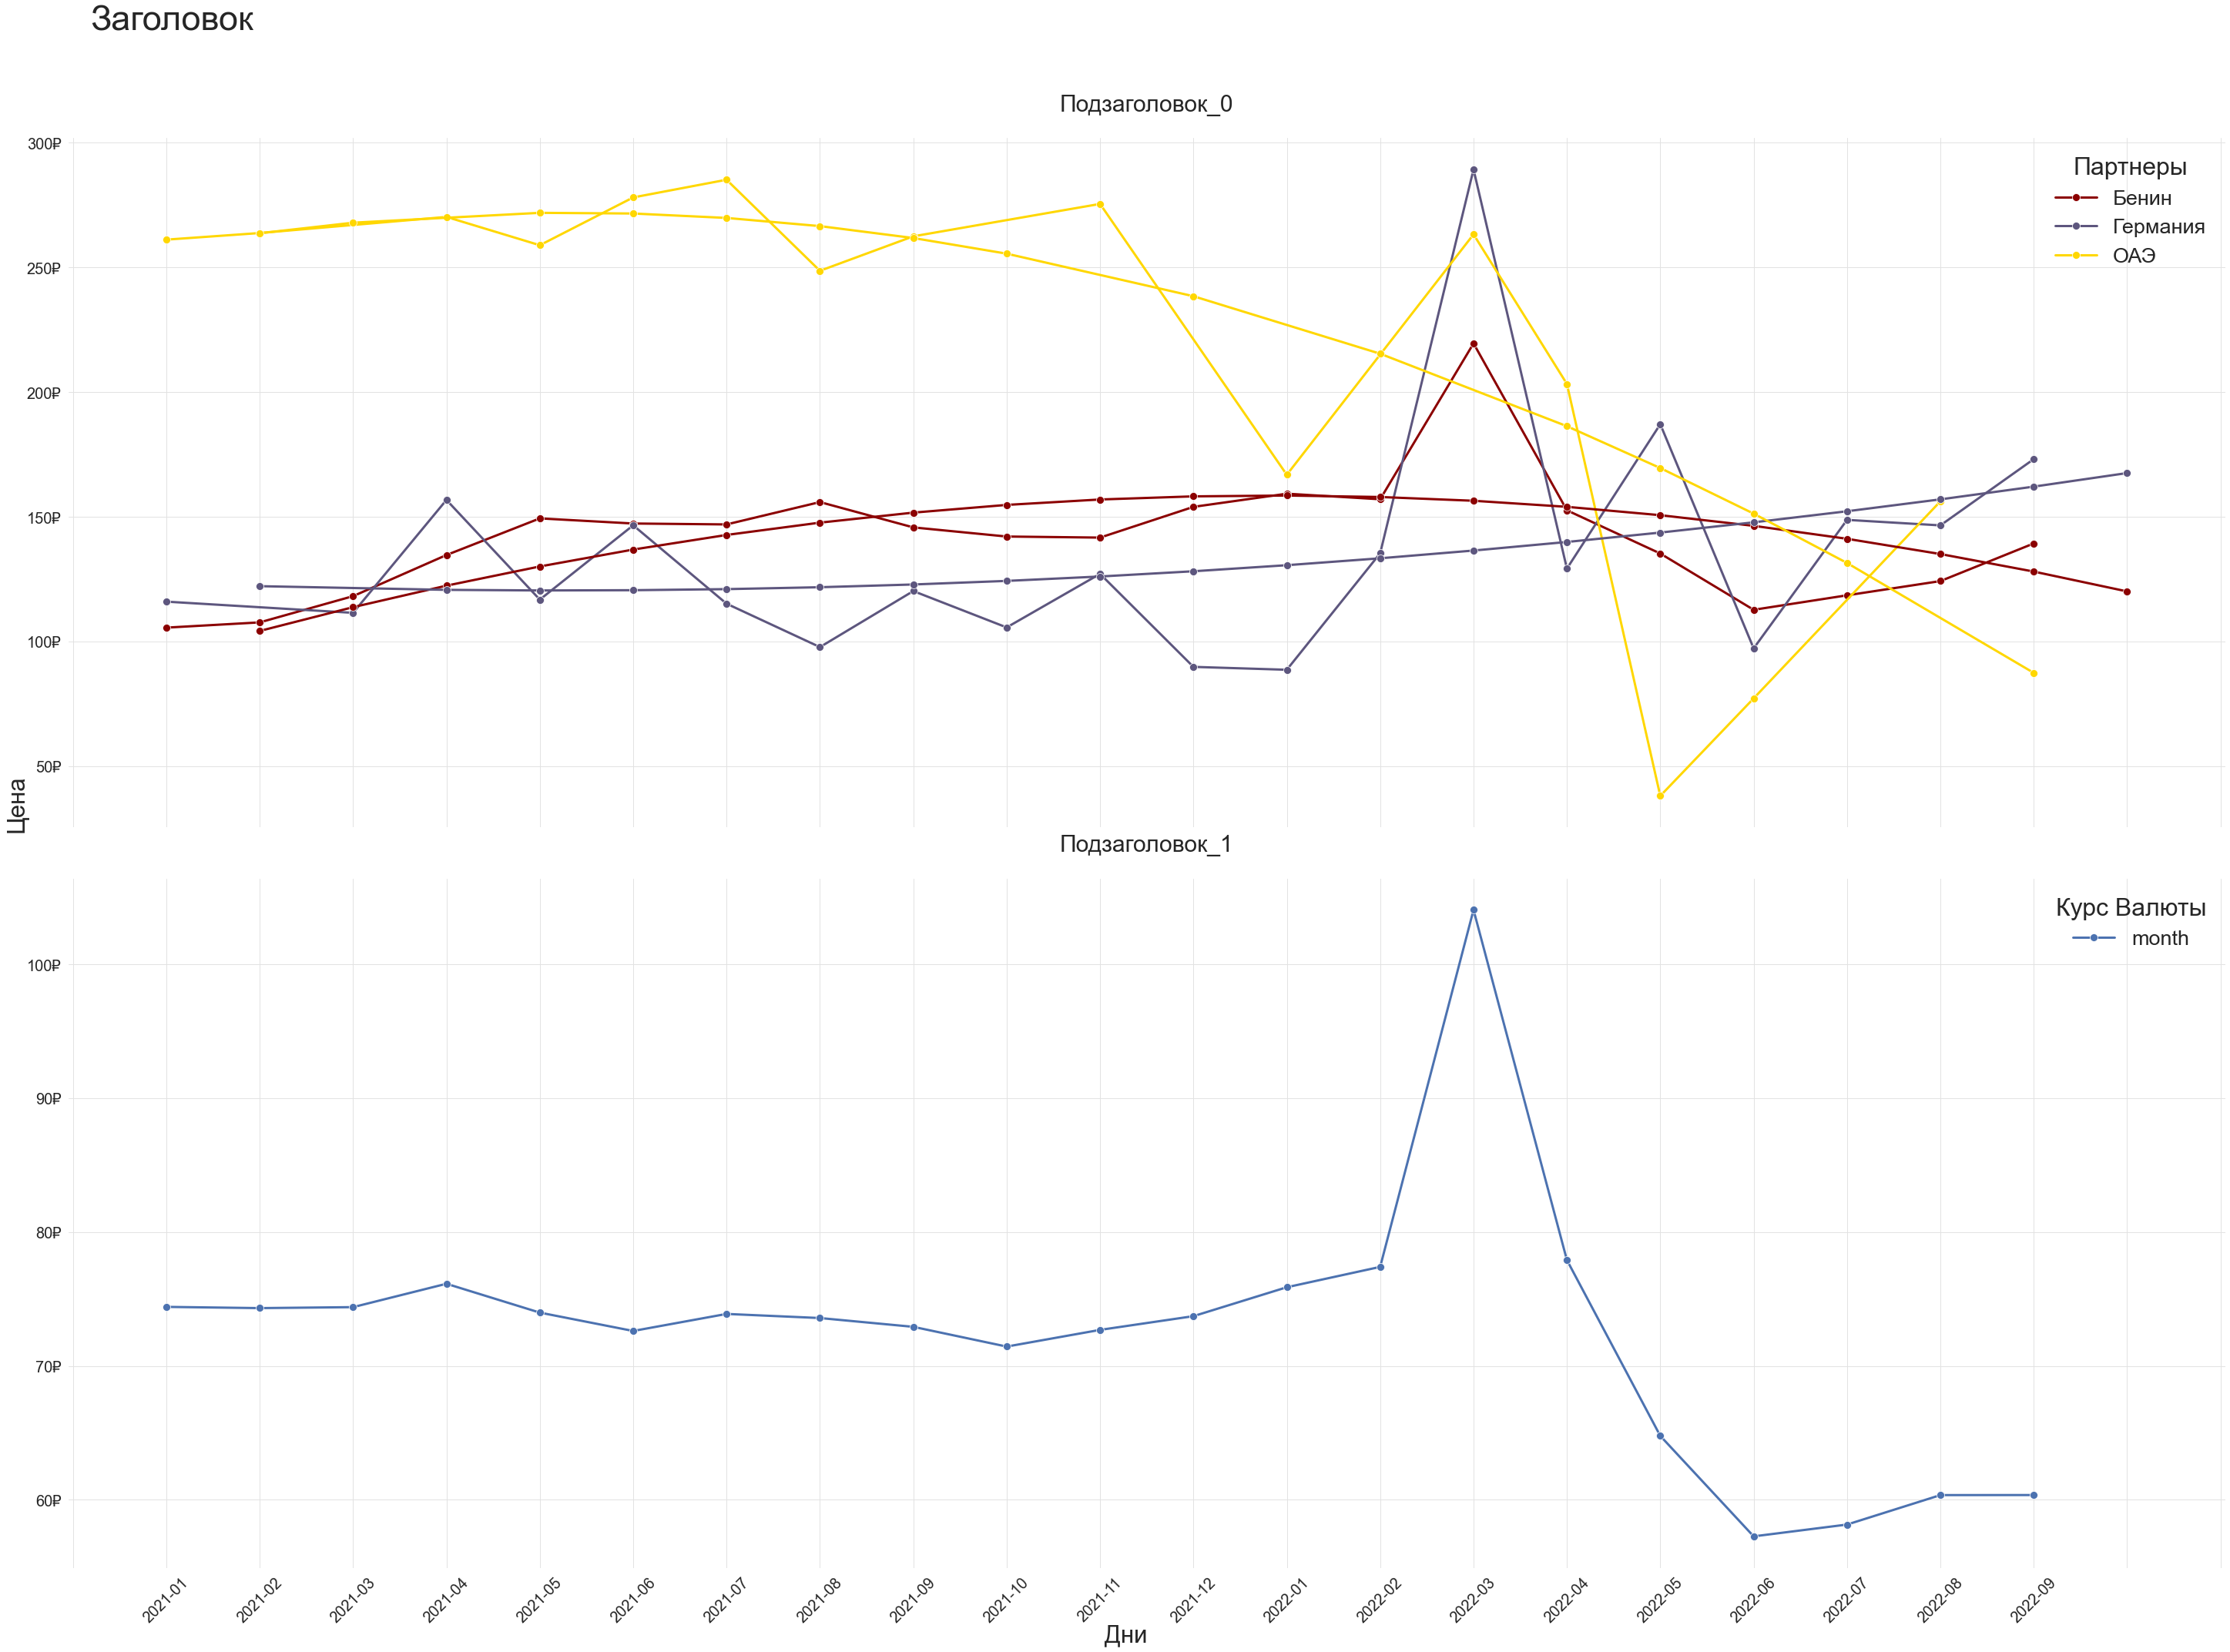

In [405]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(40, 30), sharey='row', sharex=True)

fig.suptitle('Заголовок', fontsize=45, y=0.98, x=0.07)
for ax, data_df, u, i,  in zip(axes.flatten(), [df_group, m, df_group], ['y', 's'], [int(i) for i in range(len(axes.flatten()))]):
    if u == 'y':
        test_plot(data_df, group_val='name_rus', title_legend='Партнеры', color_list=['#8B0000', '#5d567e', '#FFD700'],  ax=ax)
        
    else:
        test_plot(data_df, ax=ax, title_legend='Курс Валюты')
    
    axes[i].set_title(f'Подзаголовок_{i}', fontsize=30)
    axes[i].set_xlabel( "")
    axes[i].set_ylabel( "")
#     axes[i].legend(fontsize=30)
#     ax.legend(title='leg', loc='upper right', framealpha=0)
    
fig.text(0.00, 0.5, 'Цена', rotation='vertical', va='center', ha='center', fontsize=31)
fig.text(0.5, 0.00, 'Дни', va='center', ha='center', fontsize=31)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [39]:
query_fts = """

            SELECT SUM(trade_value), region, region_code
            FROM cc.fts l LEFT JOIN ref.ref_region r ON l.region_code = r.code
            WHERE commodity_code LIKE('020727%') AND trade_flow_code = '2'
            GROUP BY region, region_code
            ORDER BY SUM(trade_value) DESC
            LIMIT 10

"""

In [27]:
q = """

        SELECT trade_value, period, name_rus   
        FROM cc.fts l LEFT JOIN ref.ref_country r ON l.partner_code = r.code   
        WHERE  region_code = '56000' AND trade_flow_code = '2'

"""

In [40]:
df = pd.read_sql(query_fts, con=engine)

In [28]:
dfff = pd.read_sql(q, con=engine)

In [39]:
t = dfff.groupby('name_rus', as_index=False) \
                                    .agg({'trade_value':'sum'})

In [162]:
sns.set(rc={'figure.figsize':(27, 20), 'axes.titlesize':16, 'axes.labelsize':20, 'xtick.labelsize':20, 
            'ytick.labelsize':20,'axes.titlepad': 35, # 'font.family': 'Roboto' 
           })

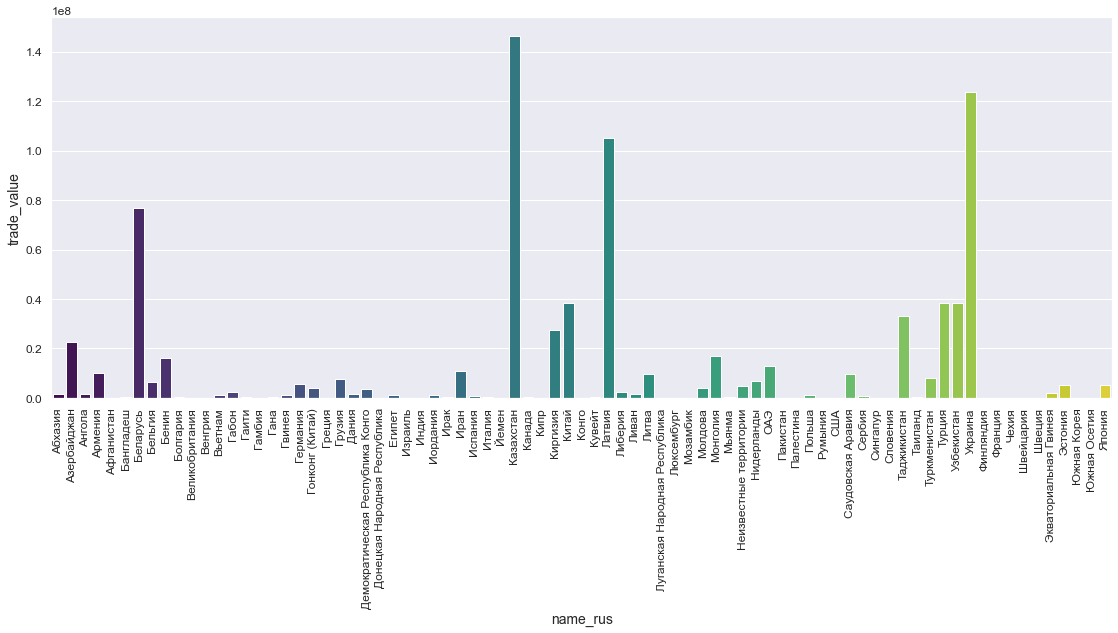

In [43]:
ax = sns.barplot(x=t.name_rus, y=t.trade_value, palette='viridis')
ax.tick_params(axis='x', rotation=90)

In [29]:
dfff

,trade_value,period,name_rus
0,1737720.0,2019-04-01,Иран
1,559990.0,2019-05-01,Иран
2,570140.0,2019-06-01,Иран
3,8850.0,2019-02-01,Иран
4,401830.0,2020-04-01,Неизвестные территории
...,...,...,...
34923,19160.0,2022-04-26,Италия
34924,20030.0,2022-05-27,Италия
34925,600.0,2022-02-01,Казахстан
34926,70.0,2022-03-01,Казахстан


In [41]:
df

,sum,region,region_code
0,76929340.0,Пензенская область,56000
1,33691700.0,Московская область,46000
2,6832650.0,г. Москва,45000
3,5280540.0,Ростовская область,60000
4,1240890.0,Республика Башкортостан,80000
5,1076390.0,Тульская область,70000
6,712210.0,Оренбургская область,53000
7,667590.0,Смоленская область,66000
8,387510.0,г. Санкт-Петербург,40000
9,383770.0,Краснодарский край,03000


In [20]:
df_2 = pd.read_sql(q, con=engine)

In [21]:
df_2

,trade_value,year
0,6710.0,2019
1,418660.0,2019
2,135000.0,2019
3,438560.0,2019
4,449520.0,2019
...,...,...
38931,20030.0,2022
38932,5150.0,2022
38933,600.0,2022
38934,70.0,2022


<AxesSubplot:xlabel='year', ylabel='trade_value'>

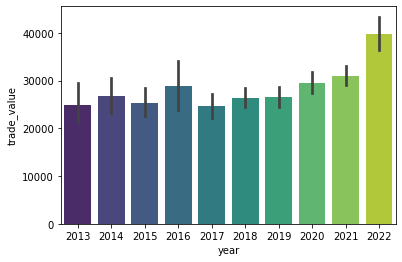

In [22]:
sns.barplot(x=df_2.year, y=df_2.trade_value, palette='viridis')